In [2]:
# Connect to Google drive, so I can import modules from it into my workspace
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = False

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_toolkit as pyt
        MODEL_SAVE_DIR = os.path.join(pyt_path, 'model_states')
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

MODEL_SAVE_DIR = ./model_states


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from tensorflow.keras.preprocessing.image import *
# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

Using Pytorch version: 1.7.1+cpu. GPU is NOT available


In [38]:
# download the data from GitHub - will download to /content folder
!git clone https://github.com/hromi/SMILEsmileD.git

fatal: destination path 'SMILEsmileD' already exists and is not an empty directory.


In [4]:
def get_data(image_paths):

  images, labels = [], []

  for image_path in image_paths:
    image = load_img(image_path, target_size=(32,32), 
                     color_mode='grayscale')
    image = img_to_array(image)
    label = image_path.split(os.path.sep) [-2]
    label = 'positive' in label
    label = int(label)
    images.append(image)
    labels.append(label)

  return np.array(images), np.array(labels)

In [6]:
if USE_COLAB:
    file_pattern = pathlib.Path('/') / 'content' / 'SMILEsmileD' / 'SMILEs' / '*' / '*' / '*.jpg'
else:
    file_pattern = pathlib.Path.home() / '.keras' / 'datasets' / 'SMILEsmileD' / 'SMILEs' / '*' / '*' / '*.jpg'

dataset_paths = [*glob.glob(str(file_pattern))]
images, labels = get_data(dataset_paths)
print(f"images.shape: {images.shape} - labels.shape: {labels.shape}")

images.shape: (13165, 32, 32, 1) - labels.shape: (13165,)


In [7]:
#images /= 255.
total = len(labels)
class_counts = [len(labels[labels == i]) for i in np.unique(labels)]
print(f"class_counts: {class_counts}")

class_counts: [9475, 3690]


In [8]:
net = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.4),
    
    nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.4),       
    
    nn.Flatten(),
    
    nn.Linear(64*6*6, 500),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(500, 2)
)

model = pytk.PytkModuleWrapper(net)
# add weights to optimizer due to class imbalance
weights = torch.FloatTensor(class_counts) / total
weights = weights.cuda() if torch.cuda.is_available() else weights.cpu()
criterion = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
print(model.summary((1, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             832
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
         MaxPool2d-4           [-1, 32, 15, 15]               0
           Dropout-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 13, 13]          51,264
              ReLU-7           [-1, 64, 13, 13]               0
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10             [-1, 64, 6, 6]               0
          Flatten-11                 [-1, 2304]               0
           Linear-12                  [-1, 500]       1,152,500
             ReLU-13                  [-1, 500]               0
          Dropout-14                  [

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, 
                                                    random_state=SEED, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, 
                                                  random_state=SEED, stratify=y_train)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}") 

X_train.shape: (7372, 32, 32, 1) - y_train.shape: (7372,) - class dist: [5306 2066]
X_val.shape: (3160, 32, 32, 1) - y_val.shape: (3160,) - class dist: [2274  886]
X_test.shape: (2633, 32, 32, 1) - y_test.shape: (2633,) - class dist: [1895  738]


In [10]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SmilesDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

In [11]:
train_dataset = SmilesDataset(X_train, y_train, image_transforms)
val_dataset = SmilesDataset(X_val, y_val, image_transforms)
test_dataset = SmilesDataset(X_test, y_test, image_transforms)

images.shape: (32, 1, 32, 32) - labels.shape: (32,)


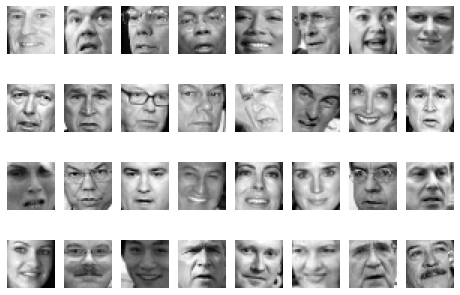

In [12]:
trainloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
data_iter = iter(trainloader)
sample_images, sample_labels = data_iter.next()
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')
plt.show()
plt.close()

In [13]:
hist = model.fit_dataset(train_dataset, epochs=20, batch_size=32, validation_dataset=val_dataset)

Training on CPU...
Training on 7372 samples, cross-validating on 3160 samples
Epoch ( 1/20): (7372/7372) -> loss: 0.2805 - acc: 0.8259 - val_loss: 0.1893 - val_acc: 0.8745 - lr: ['0.00100000']
Epoch ( 2/20): (7372/7372) -> loss: 0.1921 - acc: 0.8766 - val_loss: 0.1886 - val_acc: 0.8993 - lr: ['0.00100000']
Epoch ( 3/20): (7372/7372) -> loss: 0.1869 - acc: 0.8844 - val_loss: 0.1738 - val_acc: 0.9052 - lr: ['0.00100000']
Epoch ( 4/20): (7372/7372) -> loss: 0.1691 - acc: 0.8939 - val_loss: 0.1608 - val_acc: 0.8999 - lr: ['0.00100000']
Epoch ( 5/20): (7372/7372) -> loss: 0.1598 - acc: 0.8997 - val_loss: 0.1782 - val_acc: 0.8957 - lr: ['0.00100000']
Epoch ( 6/20): (7372/7372) -> loss: 0.1480 - acc: 0.9081 - val_loss: 0.1665 - val_acc: 0.8976 - lr: ['0.00100000']
Epoch ( 7/20): (7372/7372) -> loss: 0.1484 - acc: 0.9075 - val_loss: 0.1670 - val_acc: 0.9119 - lr: ['0.00100000']
Epoch ( 8/20): (7372/7372) -> loss: 0.1493 - acc: 0.9067 - val_loss: 0.1821 - val_acc: 0.8919 - lr: ['0.00100000']
Ep

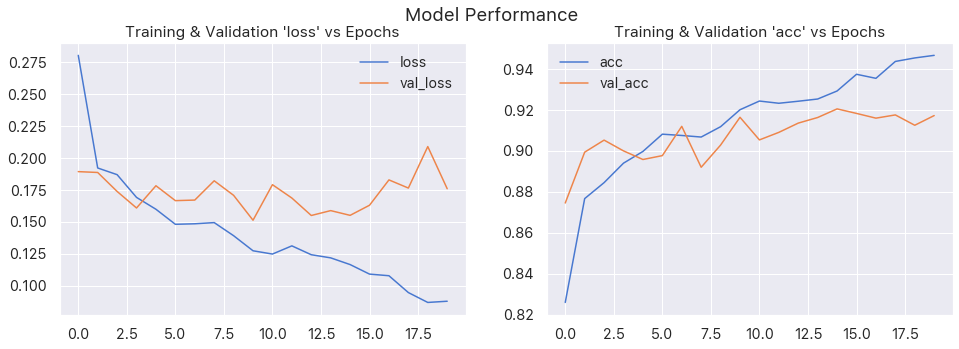

In [14]:
pytk.show_plots(hist, metric='acc', plot_title='Model Performance')

In [15]:
loss, acc = model.evaluate_dataset(train_dataset)
print(f"Training  -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(val_dataset)
print(f"Cross-val -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = model.evaluate_dataset(test_dataset)
print(f"Testing   -> loss: {loss:.3f} - acc: {acc:.3f}")

Evaluating (7372/7372) -> loss: 0.0558 - acc: 0.9736
Training  -> loss: 0.056 - acc: 0.974
Evaluating (3160/3160) -> loss: 0.1752 - acc: 0.9176
Cross-val -> loss: 0.175 - acc: 0.918
Evaluating (2633/2633) -> loss: 0.1728 - acc: 0.9200
Testing   -> loss: 0.173 - acc: 0.920


In [16]:
model.save('./model_states/pytk_smiles.pt')
del model

Pytorch model saved to ./model_states/pytk_smiles.pt


In [17]:
net = pytk.load_model('./model_states/pytk_smiles.pt')
model = pytk.PytkModuleWrapper(net)
# add weights to optimizer due to class imbalance
weights = torch.FloatTensor(class_counts) / total
weights = weights.cuda() if torch.cuda.is_available() else weights.cpu()
criterion = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
print(model.summary((1, 32, 32)))

Pytorch model loaded from ./model_states/pytk_smiles.pt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             832
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
         MaxPool2d-4           [-1, 32, 15, 15]               0
           Dropout-5           [-1, 32, 15, 15]               0
            Conv2d-6           [-1, 64, 13, 13]          51,264
              ReLU-7           [-1, 64, 13, 13]               0
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10             [-1, 64, 6, 6]               0
          Flatten-11                 [-1, 2304]               0
           Linear-12                  [-1, 500]       1,152,500
             ReLU-13                  [-1, 500]

In [18]:
probs, y_pred = model.predict_dataset(test_dataset)
y_test[:20], y_pred[:20]

(array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]))

## Using Tensorflow

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, ReLU, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [21]:
# this model is similar to the Pytorch model we used above
keras_model = Sequential([
    Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=(32,32,1)),
    ReLU(),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.4),

    Conv2D(filters=64, kernel_size=(5,5), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.4),

    Flatten(),

    Dense(500),
    ReLU(),
    Dropout(0.4),

    Dense(2, activation='softmax')
])

keras_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        832       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 64)        0

In [22]:
hist = keras_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
231/231 [==============================] - 76s 319ms/step - loss: 0.9092 - accuracy: 0.7591 - val_loss: 0.2902 - val_accuracy: 0.8759
Epoch 2/20
231/231 [==============================] - 82s 354ms/step - loss: 0.3200 - accuracy: 0.8677 - val_loss: 0.3595 - val_accuracy: 0.8408
Epoch 3/20
231/231 [==============================] - 78s 339ms/step - loss: 0.2783 - accuracy: 0.8866 - val_loss: 0.2613 - val_accuracy: 0.8927
Epoch 4/20
231/231 [==============================] - 77s 334ms/step - loss: 0.2731 - accuracy: 0.8905 - val_loss: 0.2586 - val_accuracy: 0.8962
Epoch 5/20
231/231 [==============================] - 77s 334ms/step - loss: 0.2809 - accuracy: 0.8845 - val_loss: 0.2457 - val_accuracy: 0.9016
Epoch 6/20
231/231 [==============================] - 115s 497ms/step - loss: 0.2544 - accuracy: 0.8952 - val_loss: 0.2388 - val_accuracy: 0.9047
Epoch 7/20
231/231 [==============================] - 92s 399ms/step - loss: 0.2379 - accuracy: 0.9019 - val_loss: 0.2530 - val_a

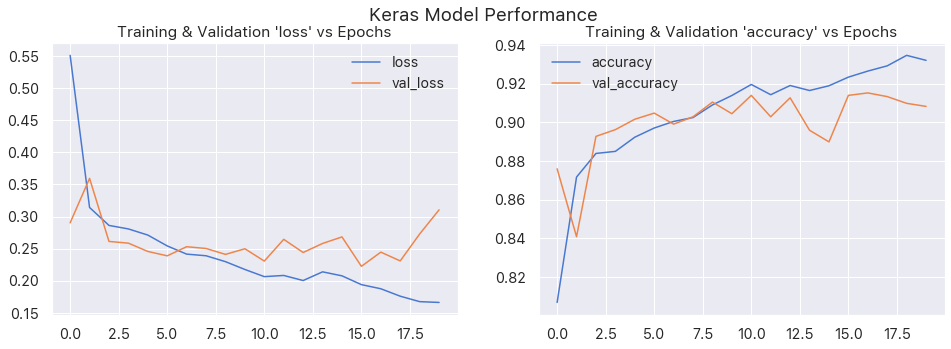

In [23]:
pytk.show_plots(hist.history, metric='accuracy', plot_title='Keras Model Performance')

In [27]:
loss, acc = keras_model.evaluate(X_train, y_train)
print(f"Training  -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = keras_model.evaluate(X_val, y_val)
print(f"Cross-val -> loss: {loss:.3f} - acc: {acc:.3f}")
loss, acc = keras_model.evaluate(X_test, y_test)
print(f"Testing   -> loss: {loss:.3f} - acc: {acc:.3f}")

231/231 [==============================] - 12s 50ms/step - loss: 0.1415 - accuracy: 0.9445
Training  -> loss: 0.142 - acc: 0.945
99/99 [==============================] - 6s 56ms/step - loss: 0.3104 - accuracy: 0.9082
Cross-val -> loss: 0.310 - acc: 0.908
83/83 [==============================] - 5s 60ms/step - loss: 0.3104 - accuracy: 0.9073
Testing   -> loss: 0.310 - acc: 0.907


In [33]:
y_pred = np.argmax(keras_model.predict(X_test), axis=1)
y_test[:30], y_pred[:30]

(array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]),
 array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]))